## Hypothesis Testing: Occupany as a proxy for demand 

Notebook By: Elizabeth Kneale 

Date: 15/03/2023

Description: This notebook will document the process used to produce the occupancy features for the hypothesis testing & feature engineering portion of the New NRP Model. 


Originally set out to analyse supply and demand internally and against our competitors to understand whether there is a relationship between supply and demand features and revenue (How much is revenue influenced by internal and
market conditions) over the same period the data will be trained on. 
- Due to limited info for competitors this would have to be done at a group level. 

Traditionally demand would be calculated using searches, but because of a lack of competitor search data and other complications arising from using the search data to develop features. 

- Due to the sheer volume of search data, we would only be able to easily process weeks/months of search data not a whole year. Searches analysis done at sporadic times is likely to be heavily influenced by marketing or micro-trends
- Search process has many layers (i.e location can be searched for in multiple ways lat/long, area, postcode). 


We are instead calculating occupany over the target period as a proxy for demand, as days booked/against days too book (utilisation), over a fixed period of time. To understand. Along with price (another hypothesis, this should give us a good indication of revenue).


This notebook will address the following statements:

        'Does occupancy by season influence revenue'

                                   &
                                   
       'Does occupancy over the year influence'
      

- Calculate internal supply (the total amount of a good or service available) and demand (the desire consumers have for a good or service) Both of these factors have a big impact on the price of goods or services. If demand increases price can increase if supply increases then price can decrease to entice demand. 


The exploration and testing phase of this work will use the following datasets:

- For internal *Demand* Property and Booking Availability [cdm].[propertymanagement].[property]
[cdm].[propertymanagement].[propertyAvailability]

___________________________________________________________________________

Versioning:

This current version looks at days customer booked/days available to do a year in the same year the revenue calculation was done


The first iteration of the work raised some concerns with the competitor information: 
1). The demand volumes appeared to be so much lower than Sykes, apart from a few regions i.e Scotland
2). Not being able to distinguish between owner and customer days could lead to wrong interpretations
3). Can't easily calculate customer booked/days available with only the the pricing table. Had to look at vol departures by total stock (Which could be easily inflated by longer season length)

To counteract this, rather than comparing compteritor vs internal trends side by side to investigate who has the market share it was decided to see compare relative product popularity

_____________________________________________________________________________

## Libraries 

In [1]:
import pandas as pd
import os
import numpy as np
import boto3
import pymssql
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#Retrieve query
def get_query(_file):
    query_file = open(_file, 'r')
    query = query_file.read()
    query_file.close()
    return query

def get_db_user(sm_name: str) -> dict:
    region_name = "eu-west-1"

    #Create a Secrets Manager client - add the profile_name parameter
    session = boto3.session.Session(profile_name='bi-production')
    client = session.client(service_name='secretsmanager'
                            ,region_name=region_name
                           )
    response = client.get_secret_value(SecretId=sm_name)
    return json.loads(response['SecretString'])

#Connect to the database
def get_db_conn(database_name, sql_code):
    server = 'BI-DATA-PROD-02.sykescottages.co.uk'
    conn = None
    db_user = get_db_user(sm_name="Data_Pipeline_Service_User")
    user=db_user['username']
    pwd=db_user['password']
    try:
        conn = pymssql.connect(server, user, pwd, database_name)
        result = pd.read_sql(sql_code, conn)
        conn.close()
    except Exception as e:
        print(f"Server connection failed: {str(e)}")
        raise
    return result

In [3]:
project_path = os.path.join(os.path.abspath(os.path.join(os.getcwd())))
DB_CDM = {'servername': 'BI-DATA-PROD-02',
          'database': 'CDM'}

In [4]:
sql_query1 = get_query(os.path.join(project_path +'/internal_occupation1.sql'))
supply2 = get_db_conn(database_name=DB_CDM['database'],
                          sql_code=sql_query1)

/var/folders/rd/fd9ml4gj2tzcpyn6vxt70mrr0000gn/T/ipykernel_35500/669184867.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(sql_code, conn)


In [8]:
# Read in the current target and propertyid to match target and data together
train_set = pd.read_csv('/Users/elizabethkneale/projects/New_NRP/NRP_2.1/Mixed Linear Effects Example/OldTargetData /train_rolling_12_2023_06_01.csv')

In [9]:
supply3 =supply2.merge(train_set[['PropertyReference','TrainLabel']],
                how='inner',
                left_on='PropertyReference',
                right_on='PropertyReference')

## Occupancy Feature Definition: Two different denominators 

*How many days the property sell of all that are available to sell?*
- Gross Occupancy - OccuAvailDays: Total days booked/ by days available including owner booked days 
*Of the days the owner gave us to sell how well does the property sell out?*
- Net Occupancy OccuJustCust: Total days booked/ by days given too us by the owner

In [10]:
cols = ['PropertyID', 'PropertyReference','Bedrooms_c', 'AllowsPets',
       'hasShortBreaksAllowed', 'WorkingRegion', 'Latitude', 'Longitude',
       'Location', 'OwnerBookingTier', 'PropertyMetalscore']
pivot_season = (supply3.assign(PropertyAvailableDaysIncOwner=
                          lambda x:(x['PropertyAvailableDays']+x['OwnerBookedDays']))
                          .assign(OccuAvailDays= 
                                  lambda x:(x['CustomerBookedDays']/
                                   x['PropertyAvailableDaysIncOwner'])*100).round(2)
                          .assign(OccuJustCust=
                                  lambda x:(x['CustomerBookedDays']/
                                   x['PropertyAvailableDays'])*100).round(2)
           .pivot(cols, 'HolidaySeason', ['OccuAvailDays', 
                                          'OccuJustCust', 
                                          'CustomerBookedDays',
                                          'OwnerBookedDays',
                                          'PropertyAvailableDays',
                                          'PropertyAvailableDaysIncOwner',
                                          'UnavailableDays'
                                                   ]).reset_index()  
           .assign(Total_OccuAvailDaysOwner=lambda x: round((x.iloc[:, 
                                                                    x.columns
                                                                    .get_level_values(0)=='CustomerBookedDays']
                                                             .sum(axis=1))/
                                                            (x.iloc[:, 
                                                                    x.columns
                                                                    .get_level_values(0)=='PropertyAvailableDaysIncOwner']
                                                             .sum(axis=1))*100,2))
                .assign(Total_OccuAvailDay=lambda x: round((x.iloc[:, 
                                                                   x.columns
                                                                   .get_level_values(0)=='CustomerBookedDays']
                                                            .sum(axis=1))/
                                                           (x.iloc[:,
                                                                   x.columns
                                                                   .get_level_values(0)=='PropertyAvailableDays']
                                                            .sum(axis=1))*100,2))
                        .assign(Total_OwnerBookedDays=lambda x: x.iloc[:, 
                                                                       x.columns
                                                                       .get_level_values(0)=='OwnerBookedDays']
                                                         .sum(axis=1))
                         .assign(Total_UnavailableDays=lambda x: x.iloc[:, 
                                                                       x.columns
                                                                       .get_level_values(0)=='UnavailableDays']
                                                         .sum(axis=1))
               )  
                         
               
#No customer days booked and no customer days available - all either owner of 
pivot_season.columns  = pivot_season.columns.map('_'.join)          

/var/folders/rd/fd9ml4gj2tzcpyn6vxt70mrr0000gn/T/ipykernel_35500/504031282.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_season = (supply3.assign(PropertyAvailableDaysIncOwner=


## Compare the Two Targets

Text(0.5, 1.0, 'Property Level - Occupancy Rating for Whole Year Comparison With and Without Owner Days')

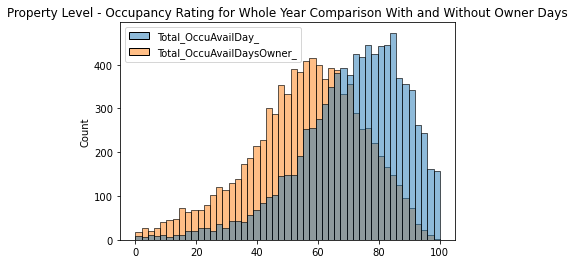

In [11]:
sns.histplot(data=pivot_season[["Total_OccuAvailDay_", "Total_OccuAvailDaysOwner_"]]).set_title('Property Level - Occupancy Rating for Whole Year Comparison With and Without Owner Days')

## Create the Groups for a group level analysis 

In [12]:
#Note revenue yearly so it will is labelled as the same for all seasons
suppT = pivot_season.merge(train_set[['TrainLabel',
             'PropertyReference']],
             how='inner',
             left_on='PropertyReference_',
             right_on='PropertyReference')
supply_aggT = suppT.groupby(['Bedrooms_c_',
                                       'AllowsPets_', 
                                       'WorkingRegion_',
                                       'hasShortBreaksAllowed_'
                             ])['TrainLabel'] .agg(['mean', 'min', 'max','median', 'count', 'std']).reset_index()
supply_aggT.head()

,Bedrooms_c_,AllowsPets_,WorkingRegion_,hasShortBreaksAllowed_,mean,min,max,median,count,std
0,1,False,Central Scotland,True,5866.305000,3646.70,8085.91,5866.305,2,3138.995494
1,1,False,Cornwall,False,4394.274286,2241.10,7213.49,4209.940,35,1362.019692
2,1,False,Cornwall,True,4138.028491,110.34,7329.94,4177.040,53,1588.255526
3,1,False,Cotswolds,False,3367.737500,1573.98,6116.51,2890.230,4,1970.427557
4,1,False,Cotswolds,True,5193.120357,1887.17,10051.64,5007.665,28,2148.991265


_____________________________________________________________________________

In [13]:
# Merge with revenue & compare both targets with revenue at season level and over the year to examine the relationship between occupany and revenue
pivot_season_rev = pivot_season.merge(train_set[['PropertyReference',
                                            'TrainLabel']],
                                      how='inner',
                                      left_on='PropertyReference_',
                                      right_on='PropertyReference')

## Yearly Occupancy By Property

- Variance of Occupancy over the year has no impact on revenue
- Higher Owner Occupancy Value the lower Revenue (Expected as we can't earn money from owner occupancy)
- Something else here causing the revenue difference (Price)

### Comparison of the gross and net targets to provide greater visability around occupancy.

In [14]:
OwnBTier_map = {'NA': 'Partial Flexibility',
 'Partial Flexibility':'Partial Flexibility',
 'C&CC Flexibility':'Partial Flexibility',
'Lakelovers Hospitality':'Partial Flexibility',
'Manor Flexibility':'Partial Flexibility',
'Heart of the lakes Hospitality':'Partial Flexibility',
'Helpful Holidays Flexibility':'Partial Flexibility'}

In [15]:
pivot_season_rev['OwnerBookingTier_'] = pivot_season_rev['OwnerBookingTier_'].fillna('Full Flexibility').replace(OwnBTier_map)

#### Points from above

- Ideally we would want properties to be in the top right hand corner (Little to no difference between occupancy of days given by customer to days occupancy with days owner booked)
- Anything along the hypotenuse has little to no difference between the 2 occupany metrics, but higher has more days sold
- The lower right vertex shows a high prop of days given by customer having sold, but a high volume of owner days as low occupany when owner days are used in the calculation.

#### Potential Factors:
- Could a difference in price be causing sellable days to not sell out
- Or the presence scenarios such as the owner only allowing bookings on some days or violation of terms/full flex be causing a large number of owner days. 


#### To Conclude:

Large variation in occupancy behaivour between days sellable and days owner booked. Can we combine the 2 fields if we used them both in the model, they might be correlated and if we only use one we run the risk of not telling the full story

## Combining the gross and net occupancy features to understand all combined occupancy behaivour

In [17]:
from sklearn.cluster import KMeans
# random cluster centroids
kmeans = KMeans(init="random",
                n_clusters=4,
                n_init=10,
                max_iter=300,
                random_state=42
               )
t = kmeans.fit(pivot_season_rev[['Total_OccuAvailDay_', 'Total_OccuAvailDaysOwner_']])

In [ ]:
pivot_season_rev['groups'] = kmeans.labels_

## Check Relationship with Revenue Target in Grouped Variable

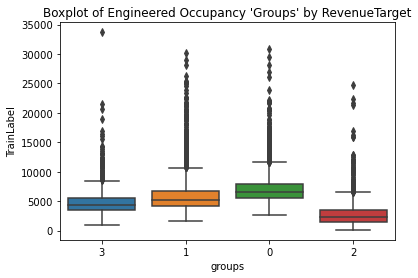

In [19]:
pivot_season_rev['groups'] = pivot_season_rev['groups'].astype(str)
sns.boxplot(data=pivot_season_rev, x='groups', y='TrainLabel',
            #hue='OwnerBookingTier_'
           #hue='Bedrooms_c'
           ).set(title="Boxplot of Engineered Occupancy 'Groups' by RevenueTarget")
plt.show()

## How Can We Infer Occupancy for New Properties Without resorting to Aggregated Values that Can Influence Ecological Fallacy

In [20]:
pivot_season_rev_test = pivot_season_rev.sample(random_state=4,
                                               frac=0.15)
pivot_season_rev_train = pivot_season_rev[~pivot_season_rev.index.isin(pivot_season_rev_test.index.tolist())]

In [21]:
pivot_season_rev_train= pivot_season_rev_train.replace({True:1,
                                                       False:0})
pivot_season_rev_train = pivot_season_rev_train.set_index('PropertyReference')

## Check the correlation of the all the potential occupancy predictors

<AxesSubplot:>

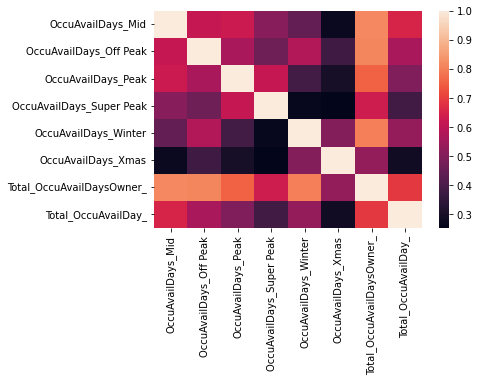

In [22]:
cols = ['OccuAvailDays_Mid', 
        'OccuAvailDays_Off Peak', 
        'OccuAvailDays_Peak',
       'OccuAvailDays_Super Peak', 
        'OccuAvailDays_Winter',
       'OccuAvailDays_Xmas',
       'Total_OccuAvailDaysOwner_',
       'Total_OccuAvailDay_',]
corr = pivot_season_rev_train[cols].corr()
#display(corr)
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Test out a Nearest Neighbours Approach to Predict New Occupancy Values

 - To see how well we can predict each potential occupancy feature from its neighbours and decide whether this could be used to calculate occupancy in the model. 
- Test out different values of K for each feature and return the model with the lowest error

In [23]:
# get dummies from owner booking tier
dummy_obt_train = pd.get_dummies(pivot_season_rev_train['OwnerBookingTier_'])
dummy_obt_test = pd.get_dummies(pivot_season_rev_test['OwnerBookingTier_'])
pivot_season_rev_train = pd.concat([pivot_season_rev_train, dummy_obt_train],axis=1)
pivot_season_rev_test= pd.concat([pivot_season_rev_test , dummy_obt_test],axis=1)
pivot_season_rev_train['OccuAvailDays_Xmas'].fillna(pivot_season_rev_train['OccuAvailDays_Xmas'].mean(),inplace=True) 
pivot_season_rev_test['OccuAvailDays_Xmas'].fillna(pivot_season_rev_test['OccuAvailDays_Xmas'].mean(),inplace=True)

In [24]:
# Need to scale the geographic features to avoid higher ranged features getting favoured
pivot_season_rev_train[['Latitude_','Longitude_']].describe()

,Latitude_,Longitude_
count,7631.000000,7631.00000
mean,52.851183,-3.15360
std,1.758953,1.86391
min,49.960000,-10.37000
25%,51.200000,-4.24000
50%,53.000000,-3.05000
75%,54.290000,-1.97000
max,58.540000,1.75000


## Run A Nearest Neighbours Algorithm to get Occupancy Predictions on all Candidate Features

In [25]:
# Whats the optimum value of k for the different targets
from sklearn.neighbors import KNeighborsRegressor, kneighbors_graph
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

k_val =[]
score = []
mse=[]
target_col = []

X_train = pivot_season_rev_train[['Bedrooms_c_', 
                                  'Full Flexibility',
                            'Off-peak Flexibility',
                            'Partial Flexibility',
                            'Existing Owners',
                            'Latitude_', 
                            'Longitude_'
                                 ]]
X_test = pivot_season_rev_test[['Bedrooms_c_', 
                            'Full Flexibility',
                            'Off-peak Flexibility',
                            'Partial Flexibility',
                            'Existing Owners',
                            'Latitude_', 
                            'Longitude_']]
target_cols = ['Total_OccuAvailDay_', 
               'Total_OccuAvailDaysOwner_', 
               'OccuAvailDays_Winter', 
               'OccuAvailDays_Mid', 
               'OccuAvailDays_Xmas', 
               'OccuAvailDays_Super Peak', 
               'OccuAvailDays_Peak', 
               'OccuAvailDays_Off Peak'
              ]
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_test)
for t in tqdm(target_cols):
    y_train = pivot_season_rev_train[t].values
    y_test = pivot_season_rev_test[t].values
    for i in range(2,31):
        neigh = KNeighborsRegressor(n_neighbors=i, algorithm='brute')
        neigh.fit(X_train_scaled, y_train)
        k_val.append(i)
        score.append(neigh.score(X_test_scaled, y_test))
        Y_pred = neigh.predict(X_test_scaled)
        MSE = np.square(np.subtract(y_test,Y_pred)).mean()
        mse.append(MSE)
        target_col.append(t)
results = pd.DataFrame(zip(target_col, k_val,score, mse), 
                       columns=['Target Col','K Value', 'Score', 'MSE'])
fin_res = results.iloc[results.groupby('Target Col')['Score'].idxmax()]
fin_res

100%|█████████████████████████████████████████████| 8/8 [00:11<00:00,  1.50s/it]


,Target Col,K Value,Score,MSE
105,OccuAvailDays_Mid,20,0.267986,411.946702
230,OccuAvailDays_Off Peak,29,0.150834,582.361753
196,OccuAvailDays_Peak,24,0.288278,394.745725
173,OccuAvailDays_Super Peak,30,0.154866,567.154979
86,OccuAvailDays_Winter,30,0.154837,426.517360
144,OccuAvailDays_Xmas,30,0.099989,1161.598414
28,Total_OccuAvailDay_,30,0.168412,249.941819
56,Total_OccuAvailDaysOwner_,29,0.265332,252.515413


In [26]:
# Whats the optimum value of k for the different targets
from sklearn.neighbors import KNeighborsRegressor, kneighbors_graph
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

k_val =[]
score = []
mse=[]
target_col = []

X_train = pivot_season_rev_train[['Bedrooms_c_', 
                                  'Full Flexibility',
                            'Off-peak Flexibility',
                            'Partial Flexibility',
                            'Existing Owners',
                            'Latitude_', 
                            'Longitude_'
                                 ]]
X_test = pivot_season_rev_test[['Bedrooms_c_', 
                            'Full Flexibility',
                            'Off-peak Flexibility',
                            'Partial Flexibility',
                            'Existing Owners',
                            'Latitude_', 
                            'Longitude_']]
target_cols = ['Total_OccuAvailDay_', 
               'Total_OccuAvailDaysOwner_', 
               'OccuAvailDays_Winter', 
               'OccuAvailDays_Mid', 
               'OccuAvailDays_Xmas', 
               'OccuAvailDays_Super Peak', 
               'OccuAvailDays_Peak', 
               'OccuAvailDays_Off Peak'
              ]
# Scaled features
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_test)
for t in tqdm(target_cols):
    y_train = pivot_season_rev_train[t].values
    y_test = pivot_season_rev_test[t].values
    for i in range(2,31):
        neigh = KNeighborsRegressor(n_neighbors=i, algorithm='brute')
        neigh.fit(X_train_scaled, y_train)
        k_val.append(i)
        score.append(neigh.score(X_test_scaled, y_test))
        Y_pred = neigh.predict(X_test_scaled)
        MSE = np.square(np.subtract(y_test,Y_pred)).mean()
        mse.append(MSE)
        target_col.append(t)
results = pd.DataFrame(zip(target_col, k_val,score, mse), 
                       columns=['Target Col','K Value', 'Score', 'MSE'])
fin_res = results.iloc[results.groupby('Target Col')['Score'].idxmax()]
fin_res

100%|█████████████████████████████████████████████| 8/8 [00:11<00:00,  1.39s/it]


,Target Col,K Value,Score,MSE
105,OccuAvailDays_Mid,20,0.267986,411.946702
230,OccuAvailDays_Off Peak,29,0.150834,582.361753
196,OccuAvailDays_Peak,24,0.288278,394.745725
173,OccuAvailDays_Super Peak,30,0.154866,567.154979
86,OccuAvailDays_Winter,30,0.154837,426.517360
144,OccuAvailDays_Xmas,30,0.099989,1161.598414
28,Total_OccuAvailDay_,30,0.168412,249.941819
56,Total_OccuAvailDaysOwner_,29,0.265332,252.515413


In [28]:
# Error Magnitude test for actual vs predicted occupancy
print((pivot_season_rev_test[(pivot_season_rev_test['error'] >-5) & 
                      (pivot_season_rev_test['error'] <5)].shape[0])
      /pivot_season_rev_test.shape[0]*100)
print((pivot_season_rev_test[(pivot_season_rev_test['error'] >-10) & 
                      (pivot_season_rev_test['error'] <10)].shape[0])
      /pivot_season_rev_test.shape[0]*100)
print((pivot_season_rev_test[(pivot_season_rev_test['error'] >-15) & 
                      (pivot_season_rev_test['error'] <15)].shape[0])
      /pivot_season_rev_test.shape[0]*100)
print((pivot_season_rev_test[(pivot_season_rev_test['error'] >-20) & 
                      (pivot_season_rev_test['error'] <20)].shape[0])
      /pivot_season_rev_test.shape[0]*100)
print((pivot_season_rev_test[(pivot_season_rev_test['error'] >-25) & 
                      (pivot_season_rev_test['error'] <25)].shape[0])
      /pivot_season_rev_test.shape[0]*100)
print((pivot_season_rev_test[(pivot_season_rev_test['error'] >-30) & 
                      (pivot_season_rev_test['error'] <30)].shape[0])
      /pivot_season_rev_test.shape[0]*100)
print((pivot_season_rev_test[(pivot_season_rev_test['error'] >-50) & 
                      (pivot_season_rev_test['error'] <50)].shape[0])
      /pivot_season_rev_test.shape[0]*100)

21.974758723088346
42.01930215293244
59.391239792130655
72.08611729769859
82.92501855976244
89.53229398663697
99.03489235337788


## How do the new the features fare in the model

- Retrain the KNN model on the same train set as the model and the ones that don't map across. As we won't be using these to test the model

In [91]:
t = pd.read_csv('/Users/elizabethkneale/projects/New_NRP/NRP_2.1/supply_demand/final_supply_demand/train_nrp_2023_06_01.csv')

In [30]:
pivot_season_rev['OccuAvailDays_Xmas'].fillna(pivot_season_rev['OccuAvailDays_Xmas'].mean(),inplace=True)
dummy_obt = pd.get_dummies(pivot_season_rev['OwnerBookingTier_'])
pivot_season_rev = pd.concat([pivot_season_rev, dummy_obt],axis=1)
occup_feat_train0 = pivot_season_rev[['PropertyReference_',
                  'Bedrooms_c_',
                  'Full Flexibility',
                  'Off-peak Flexibility',
                   'Partial Flexibility',
                   'Existing Owners',
                  'Latitude_',
                  'Longitude_',
                  'OccuAvailDays_Mid', 
                  'OccuAvailDays_Off Peak',
                  'OccuAvailDays_Peak',
                  'OccuAvailDays_Super Peak', 
                  'OccuAvailDays_Winter',
                  'OccuAvailDays_Xmas',
                  'Total_OccuAvailDaysOwner_',
                  'Total_OccuAvailDay_', 'groups', 'TrainLabel']]
test_set = pd.read_csv('/Users/elizabethkneale/projects/New_NRP/NRP_2.1/Mixed Linear Effects Example/OldTargetData /test_rolling_12_2023_06_01.csv')
occup_feat_test0 = pivot_season_rev.merge(test_set,
                                         how='inner',
                                         left_on='PropertyReference_',
                                         right_on='PropertyReference')

In [31]:
# Train the KNN on the train sample and test on the test sample that aren't in the train sample
extra= list(set(occup_feat_train0.PropertyReference_.tolist()) - set(occup_feat_test0.PropertyReference_.tolist()))



_________________________________________________________________________________

### Train the KNN model on the training set and the unused sample

- Split this into a train and validation set and use unused set, to see how well it can predict revenue
- Use the brute algorithm 

In [32]:
# Train and unused sample, to train the model on 
knn_df = occup_feat_train0[~occup_feat_train0['PropertyReference_'].isin(extra)]
knn_X_test = knn_df.sample(random_state=4, frac=0.20)
knn_X_train = knn_df[~knn_df.index.isin(knn_X_test.index.tolist())]
knn_val = occup_feat_train0[occup_feat_train0['PropertyReference_'].isin(extra)]

In [33]:
# Whats the optimum value of k for the different targets
from sklearn.neighbors import KNeighborsRegressor, kneighbors_graph
import scikitplot as skplt

k_val =[]
score = []
mse=[]
target_col = []
model_list =[]

knn_cols = ['Full Flexibility',
            'Off-peak Flexibility',
            'Partial Flexibility',
            'Existing Owners',
            'Bedrooms_c_',
            'Latitude_',
            'Longitude_']

target_cols = ['Total_OccuAvailDay_', 
               'Total_OccuAvailDaysOwner_', 
               'OccuAvailDays_Winter', 
               'OccuAvailDays_Mid', 
               'OccuAvailDays_Xmas', 
               'OccuAvailDays_Super Peak', 
               'OccuAvailDays_Peak', 
               'OccuAvailDays_Off Peak'
              ]
scaler = MinMaxScaler()
knn_X_train_scaled, knn_X_test_scaled = scaler.fit_transform(knn_X_train[knn_cols]), scaler.fit_transform(knn_X_test[knn_cols])
for t in tqdm(target_cols):
    knn_y_train, knn_y_test = knn_X_train[t].values, knn_X_test[t].values
    for i in range(2,31):
        neigh = KNeighborsRegressor(n_neighbors=i, algorithm='brute') #brute because the model isn't that big so training won't take too long
        neigh.fit(knn_X_train_scaled, knn_y_train)
        k_val.append(i)
        score.append(neigh.score(knn_X_test_scaled, knn_y_test))
        Y_pred = neigh.predict(knn_X_test_scaled)
        MSE = np.square(np.subtract(knn_y_test,Y_pred)).mean()
        mse.append(MSE)
        target_col.append(t)
        model_list.append(neigh)
results = pd.DataFrame(zip(target_col, k_val,score, mse, model_list), 
                       columns=['Target Col','K Value', 
                                'Score', 'MSE', 'Model'])
fin_res = results.iloc[results.groupby('Target Col')['Score'].idxmax()]
fin_res

100%|█████████████████████████████████████████████| 8/8 [00:13<00:00,  1.67s/it]


,Target Col,K Value,Score,MSE,Model
111,OccuAvailDays_Mid,26,0.245403,412.121179,"KNeighborsRegressor(algorithm='brute', n_neigh..."
231,OccuAvailDays_Off Peak,30,0.145620,556.031235,"KNeighborsRegressor(algorithm='brute', n_neigh..."
197,OccuAvailDays_Peak,25,0.246202,399.630348,"KNeighborsRegressor(algorithm='brute', n_neigh..."
169,OccuAvailDays_Super Peak,26,0.160654,542.356301,"KNeighborsRegressor(algorithm='brute', n_neigh..."
85,OccuAvailDays_Winter,29,0.184463,444.586064,"KNeighborsRegressor(algorithm='brute', n_neigh..."
144,OccuAvailDays_Xmas,30,0.122198,1083.927969,"KNeighborsRegressor(algorithm='brute', n_neigh..."
14,Total_OccuAvailDay_,16,0.130212,252.692738,"KNeighborsRegressor(algorithm='brute', n_neigh..."
53,Total_OccuAvailDaysOwner_,26,0.267903,251.006874,"KNeighborsRegressor(algorithm='brute', n_neigh..."


## Create the KNN values to add to the test set 

- To compare against actual test set values on how well they predict revenue 

For each target see which performs better the actual occupancy or the predicted for each

### Catboost

In [34]:
from tqdm import tqdm
import catboost as ctb

In [35]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [60]:
initial_cat_features = ['BrandID', 'AllowsPets', 'ChangeOverDay', 
                        'PropertyType', 'Rating', 'isHoneyPot', 
                        'LocationType', 'WorkingRegion', 'RevenueManagementOption', 
                        'hasBroadband', 'hasDishwasher', 'hasEnclosedGarden', 
                        'hasGames', 'hasGarden', 'hasHotTub', 'hasIndoorPool', 
                        'hasOffRoadParking', 'hasOpenFire','OwnerBookingTier', 
                        'hasShortBreaksAllowed', 'hasLastMinuteBreakAllowed', 
                        'OpenFireType', 'daily', 'owner_led_pricing', 
                        'ClusterLabel']

initial_num_features = ['Bathrooms', 'Bedrooms','Sleeps',
'CommissionRate','RelativePixels', 'Number_Pictures',
'YearLastUpdate', 'HPOccupancy','WorkingRegionOccupancy', 
'BedsOccupancy', 'PeakAsAtOwnerBooking','MidAsAtOwnerBooking', 
'OffPeakAsAtOwnerBooking','SuperPeakAsAtOwnerBooking', 
'WinterAsAtOwnerBooking','XmasAsAtOwnerBooking']

original_features = ['BrandID', 'AllowsPets', 'ChangeOverDay', 
                        'PropertyType', 'Rating', 'isHoneyPot', 
                        'LocationType', 'WorkingRegion', 'RevenueManagementOption', 
                        'hasBroadband', 'hasDishwasher', 'hasEnclosedGarden', 
                        'hasGames', 'hasGarden', 'hasHotTub', 'hasIndoorPool', 
                        'hasOffRoadParking', 'hasOpenFire','OwnerBookingTier', 
                        'hasShortBreaksAllowed', 'hasLastMinuteBreakAllowed', 
                        'OpenFireType', 'daily', 'owner_led_pricing', 
                        'ClusterLabel', 'Bathrooms', 'Bedrooms','Sleeps',
                     'CommissionRate','RelativePixels', 'Number_Pictures',
                     'YearLastUpdate', 'HPOccupancy','WorkingRegionOccupancy', 
                     'BedsOccupancy', 'PeakAsAtOwnerBooking','MidAsAtOwnerBooking', 
                     'OffPeakAsAtOwnerBooking','SuperPeakAsAtOwnerBooking', 
                     'WinterAsAtOwnerBooking','XmasAsAtOwnerBooking']



candidate_variables = ['Total_OccuAvailDaysOwner_', 'Total_OccuAvailDay_', 
                        'groups',['OccuAvailDays_Mid', 'OccuAvailDays_Off Peak', 
                                     'OccuAvailDays_Peak', 'OccuAvailDays_Super Peak',
                                     'OccuAvailDays_Winter', 'OccuAvailDays_Xmas']]

                    
# Train and unused sample, to train the model on 
occup_feat_test0 = occup_feat_test0.rename(columns={'TrainLabel':'Target'})
catboost_X_test = occup_feat_test0.sample(random_state=4, frac=0.20)
catboost_X_train =  occup_feat_test0[~occup_feat_test0.index.isin(catboost_X_test.index.tolist())]
catboost_val = pivot_season_rev[pivot_season_rev['PropertyReference_'].isin(extra)]
catboost_val = catboost_val.rename(columns={'TrainLabel':'Target'})
catboost_X_train.head()

In [72]:
catboost_X_train.columns = catboost_X_train.columns.str.rstrip('_')
catboost_X_test.columns = catboost_X_test.columns.str.rstrip('_')

In [ ]:
def occupancy_vars_test1(train, 
                        test,
                        exp_desc):
    
    SMAPE = []
    X_train, y_train = train[initial_num_features 
                                         + initial_cat_features],train['Target'].values
    
    
    model_params = {'iterations':1600} 
    model = ctb.CatBoostRegressor(**model_params)
    model.fit(X=X_train, 
          y=y_train, 
          cat_features=initial_cat_features,
         verbose=False
          #,plot=True)
         )
    
    X_test, y_test = test[initial_num_features 
                                            +initial_cat_features], test['Target'].values
        
    expected  = y_test
    predicted = model.predict(X_test)
    #print(metrics.r2_score(expected, predicted))
    #print(metrics.mean_squared_log_error(expected, predicted))
    SMAPE.append(smape(a=expected, f=predicted))
    res = pd.DataFrame(np.array(SMAPE).reshape(-1,len(SMAPE))
                       ,columns=['Year 1 sMAPE', 'Year 2 sMAPE']
                       ,index=[exp_desc])
    
    return res

In [ ]:
# Drop values in list if not in i or others 
num_tar = []
t = occupancy_vars_test1(train=catboost_X_train, 
                test=catboost_X_test, 
                exp_desc='No Extra Variables')

In [ ]:
# Drop values in list if not in i or others 
num_tar = []
t = occupancy_vars_test1(train=catboost_X_train, 
                test=catboost_X_test, 
                exp_desc='No Extra Variables')
#print(t)
for i in tqdm(candidate_variables):
    if i == 'groups':
        initial_cat_features.append(i)
        a=occupancy_vars_test1(train=catboost_X_train, 
                test=catboost_X_test, 
                exp_desc=f"Add {i}")
        initial_cat_features = [x for x in initial_cat_features if x in original_features]
        
        #print(a)
    elif isinstance(i, list):
        for item in i:
            initial_num_features.append(item)
        b=occupancy_vars_test1(train=catboost_X_train, 
                               test=catboost_X_test, 
                               exp_desc=f"Add {i}")
        initial_num_features = [x for x in initial_num_features if x in original_features]
        #print(b)
    else:
        initial_num_features.append(i)
        c=occupancy_vars_test1(train=catboost_X_train, 
                                test=catboost_X_test, 
                                exp_desc=f"Add {i}")
        num_tar.append(c)
        initial_num_features = [x for x in initial_num_features if x in original_features]

final=pd.concat([t,a,b,pd.concat([num_tar[0], num_tar[1]])])
final

## Model with the predicted values to see how well works

In [401]:
#Use the KNN model to predict 
occup_feat_test0_y1knn_pred =  occup_feat_test0_y1.copy()
occup_feat_test0_y2knn_pred =  occup_feat_test0_y2.copy()
for i in range(len(fin_res)):
    year1_pred = fin_res.iloc[i,-1].predict(occup_feat_test0_y1knn_pred[knn_cols])
    year2_pred = fin_res.iloc[i,-1].predict(occup_feat_test0_y2knn_pred[knn_cols])
    occup_feat_test0_y1knn_pred[f"{fin_res.iloc[i,0]}_knn_predict"] = year1_pred
    occup_feat_test0_y2knn_pred[f"{fin_res.iloc[i,0]}_knn_predict"] = year2_pred

#Drop the original values
cols_to_drop = ['OccuAvailDays_Mid', 'OccuAvailDays_Off Peak', 'OccuAvailDays_Peak',
       'OccuAvailDays_Super Peak', 'OccuAvailDays_Winter',
       'OccuAvailDays_Xmas', 'Total_OccuAvailDaysOwner', 'Total_OccuAvailDays']
occup_feat_test0_y1knn_pred1 = occup_feat_test0_y1knn_pred.drop(columns=cols_to_drop)
occup_feat_test0_y2knn_pred1 = occup_feat_test0_y2knn_pred.drop(columns=cols_to_drop)

In [403]:
# Switch the names back to 
col_names = {'OccuAvailDays_Mid_knn_predict':'OccuAvailDays_Mid', 
 'OccuAvailDays_Off Peak_knn_predict':'OccuAvailDays_Off Peak', 
 'OccuAvailDays_Peak_knn_predict':'OccuAvailDays_Peak',
  'OccuAvailDays_Super Peak_knn_predict':'OccuAvailDays_Super Peak',
 'OccuAvailDays_Winter_knn_predict': 'OccuAvailDays_Winter',
 'OccuAvailDays_Xmas_knn_predict':'OccuAvailDays_Xmas', 
 'Total_OccuAvailDaysOwner_knn_predict':'Total_OccuAvailDaysOwner',
 'Total_OccuAvailDays_knn_predict':'Total_OccuAvailDays', 
 #'TrainLabel': 'Target',
 #'TestLabel': 'Target'
            }
occup_feat_test0_y1knn_pred1.rename(col_names,axis='columns', inplace=True)
occup_feat_test0_y2knn_pred1.rename(col_names, axis='columns',inplace=True)

In [404]:
num_tar =[]
t = occupancy_vars_test1(train=occup_feat_train0, 
                test_y1=occup_feat_test0_y1knn_pred1, 
                test_y2=occup_feat_test0_y2knn_pred1,
                exp_desc='No Extra Variables')
#print(t)
for i in tqdm(candidate_variables):
    if i == 'groups':
        initial_cat_features.append(i)
        a=occupancy_vars_test1(train=occup_feat_train0, 
                test_y1=occup_feat_test0_y1knn_pred1, 
                test_y2=occup_feat_test0_y2knn_pred1, 
                exp_desc=f"Add KNN inferred values {i}")
        initial_cat_features = [x for x in initial_cat_features if x in original_features]
        
        #print(a)
    elif isinstance(i, list):
        for item in i:
            initial_num_features.append(item)
        b=occupancy_vars_test1(train=occup_feat_train0, 
                               test_y1=occup_feat_test0_y1knn_pred1, 
                               test_y2=occup_feat_test0_y2knn_pred1, 
                               exp_desc=f"Add KNN inferred values {i}")
        initial_num_features = [x for x in initial_num_features if x in original_features]
        #print(b)
    else:
        initial_num_features.append(i)
        c=occupancy_vars_test1(train=occup_feat_train0, 
                                test_y1=occup_feat_test0_y1knn_pred1, 
                                test_y2=occup_feat_test0_y2knn_pred1, 
                                exp_desc=f"Add KNN inferred values {i}")
        #print(c)
        num_tar.append(c)
        initial_num_features = [x for x in initial_num_features if x in original_features]

        
final2 = pd.concat([t,a,b, pd.concat([num_tar[0], num_tar[1]])])

100%|█████████████████████████████████████████████| 4/4 [00:31<00:00,  7.98s/it]


,Year 1 sMAPE,Year 2 sMAPE
No Extra Variables,14.930128,24.455824
Add KNN inferred values groups,12.586001,21.488959
"Add KNN inferred values ['OccuAvailDays_Mid', 'OccuAvailDays_Off Peak', 'OccuAvailDays_Peak', 'OccuAvailDays_Super Peak', 'OccuAvailDays_Winter', 'OccuAvailDays_Xmas']",21.019101,29.308980
Add KNN inferred values Total_OccuAvailDaysOwner,19.886381,28.958654
Add KNN inferred values Total_OccuAvailDays,16.058739,25.160042


## Merge the trained actual value results with the trained knn values 

In [410]:
pd.concat([final.reset_index(),final2.reset_index()], axis=1)

,index,Year 1 sMAPE,Year 2 sMAPE,index,Year 1 sMAPE,Year 2 sMAPE
0,No Extra Variables,14.930128,24.455824,No Extra Variables,14.930128,24.455824
1,Add groups,12.586001,21.488959,Add KNN inferred values groups,12.586001,21.488959
2,"Add ['OccuAvailDays_Mid', 'OccuAvailDays_Off P...",10.456880,20.472105,"Add KNN inferred values ['OccuAvailDays_Mid', ...",21.019101,29.308980
3,Add Total_OccuAvailDaysOwner,10.441608,20.539750,Add KNN inferred values Total_OccuAvailDaysOwner,19.886381,28.958654
4,Add Total_OccuAvailDays,12.343565,20.654921,Add KNN inferred values Total_OccuAvailDays,16.058739,25.160042


______________________________________________________________________________